In [ ]:
import warnings 
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime
import random
import time
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import DBSCAN
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler


from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,BatchNormalization
from keras.regularizers import l2
from xgboost import XGBRegressor

try:
    import gmplot
    import googlemaps
except ImportError:
    %pip install gmplot googlemaps 
    import gmplot
    import googlemaps

In [3]:
import os
from dotenv import load_dotenv
from pathlib import Path

dotenv_path = Path(os.getcwd()).parent / '.env'
load_dotenv(dotenv_path=dotenv_path)

True

In [4]:
train_df = pd.read_csv("../data/raw/train.csv",index_col='row_id')
test_df = pd.read_csv("../data/raw/test.csv",index_col='row_id')
combine = [train_df,test_df] 

train_df.head()

,start_lng,start_lat,end_lng,end_lat,datetime,duration
row_id,,,,,,
0,-73.783279,40.644718,-73.963799,40.681320,2015-01-09 00:51:48,1815.0
1,-122.422385,37.789408,-122.419890,37.766692,2012-09-14 01:46:00,300.0
2,-73.885292,40.773060,-74.000076,40.761360,2015-04-19 20:26:57,2620.0
3,-122.401603,37.788975,-122.410958,37.796447,2012-09-03 23:48:00,360.0
4,-74.008728,40.714317,-74.006432,40.731720,2015-01-21 12:14:45,582.0


In [5]:
print(f"train_df columns: {train_df.columns}\n")
print(f"test_df columns: {test_df.columns}")

train_df columns: Index(['start_lng', 'start_lat', 'end_lng', 'end_lat', 'datetime', 'duration'], dtype='object')

test_df columns: Index(['start_lng', 'start_lat', 'end_lng', 'end_lat', 'datetime'], dtype='object')


In [6]:
print(f"train shape: {train_df.shape}")
print(f"test shape: {test_df.shape}")

train shape: (146001, 6)
test shape: (30000, 5)


In [7]:
train_df.isnull().sum()

start_lng    400
start_lat      0
end_lng        0
end_lat      600
datetime       0
duration       0
dtype: int64

In [8]:
test_df.isnull().sum()

start_lng    0
start_lat    0
end_lng      0
end_lat      0
datetime     0
dtype: int64

# EDA

In [9]:
train_df.describe()

,start_lng,start_lat,end_lng,end_lat,duration
count,145601.000000,146001.000000,146001.000000,145401.000000,146001.000000
mean,-86.465695,39.913703,-87.177163,39.922772,1063.222314
std,25.468467,1.339508,22.225753,1.336437,3305.905829
min,-122.515832,37.459648,-122.634420,37.225640,0.000000
25%,-122.393532,37.798430,-122.392458,37.800318,382.000000
50%,-73.989830,40.741089,-73.988754,40.740990,631.000000
75%,-73.974190,40.762104,-73.971245,40.762669,1020.000000
max,74.100212,40.994354,-50.336068,41.005390,42168.000000


In [10]:
# Visualize training data points
GOOGLE_MAPS_API_KEY = os.getenv('GOOGLE_MAPS_API_KEY')

if GOOGLE_MAPS_API_KEY: 

    clean_train_df = train_df.dropna(subset=['start_lat', 'start_lng'])
    print(f"Original data points: {len(train_df)}")
    print(f"Clean data points: {len(clean_train_df)}")
    print(f"Removed {len(train_df) - len(clean_train_df)} rows with missing coordinates")
        
    gmap = gmplot.GoogleMapPlotter(
        clean_train_df.start_lat.mean(),
        clean_train_df.start_lng.mean(),
        4,
        apikey=GOOGLE_MAPS_API_KEY
    )
        
    gmap.heatmap(clean_train_df.start_lat, clean_train_df.start_lng)
        
    output_file = "gmaps/train_data_location.html"
    gmap.draw(output_file)
    print(f"Map saved to: {output_file}")

else:
    print("please add Api Key")

Original data points: 146001
Clean data points: 145601
Removed 400 rows with missing coordinates
Map saved to: gmaps/train_data_location.html


on opening the train_data_location.html we can see that main data points are in san francisco and new york. some data points are also in kyrgystan. (look at the images in the notebooks/figures folder)

In [11]:
#converting to datetime and dropping NA's
for df in combine:
    df.datetime = pd.to_datetime(df.datetime)
    df.dropna(axis=0,inplace=True)

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 145001 entries, 0 to 146000
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   start_lng  145001 non-null  float64       
 1   start_lat  145001 non-null  float64       
 2   end_lng    145001 non-null  float64       
 3   end_lat    145001 non-null  float64       
 4   datetime   145001 non-null  datetime64[ns]
 5   duration   145001 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 7.7 MB


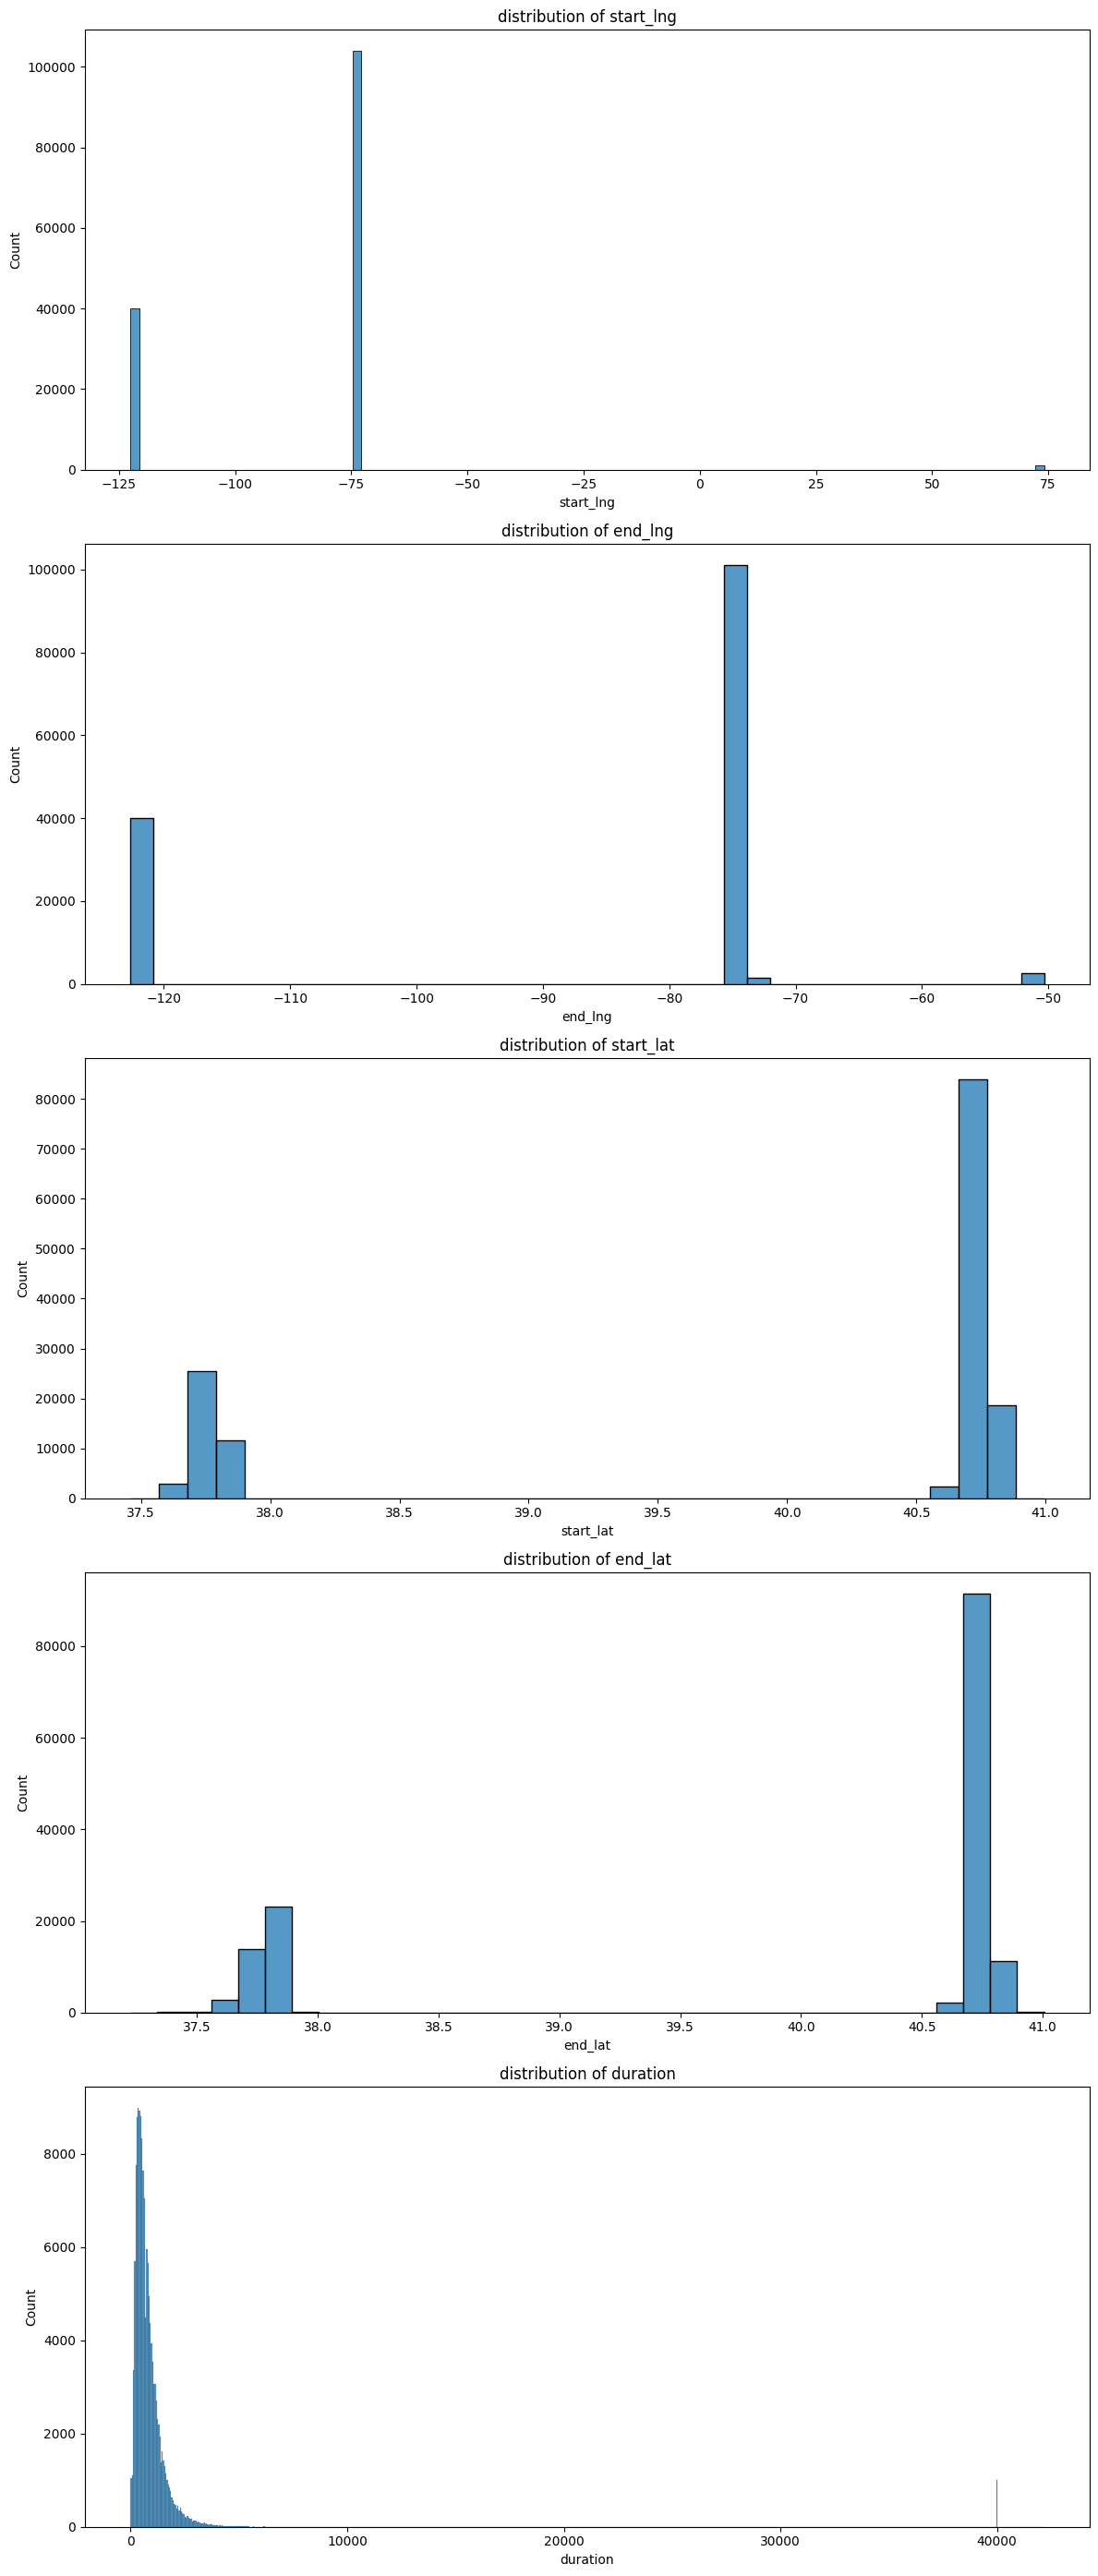

In [13]:
columns = ['start_lng','end_lng','start_lat','end_lat','duration']

fig,axes = plt.subplots(5,1,figsize=(12,28))

for i,col in enumerate(columns):
    sns.histplot(train_df[col],ax=axes[i])
    axes[i].set_title(f"distribution of {col}")

plt.tight_layout()
plt.show()

by looking at the distribution plots: 
1. start_lng and end_lng: 
- most data is around -70 to -75 which are New York Coordinates
- there are small spikes after -120 which are san francisco coordinates
- theres also a weird spike near +70 which can be invalid

2. start_lat and end_lat: 
- main cluster around 40 - 41 : NYC
- another cluster around 37 - 39 : San Francisco
- clearly two different cities mixed in this dataset

3. duration: 
- most trips are short (<5000 seconds which is roughly 1.5 hours)
- but theres a long tail reaching 40,000 sec (~11hrs)
- this distribution is highly skewed

# Removal of Outliers & Noise

### Invalid Routes

In [14]:
train_df.drop([90810, 81553, 83473, 87892, 96380], axis=0, inplace=True)

### Working with **duration**

In [15]:
#Dropping zero durations
zero_durations = (train_df.duration == 0) & ((train_df.start_lng != train_df.end_lng)|(train_df.start_lat != train_df.end_lat))
train_df.drop(train_df.loc[zero_durations].index,axis=0,inplace=True)

Before dropping duration values


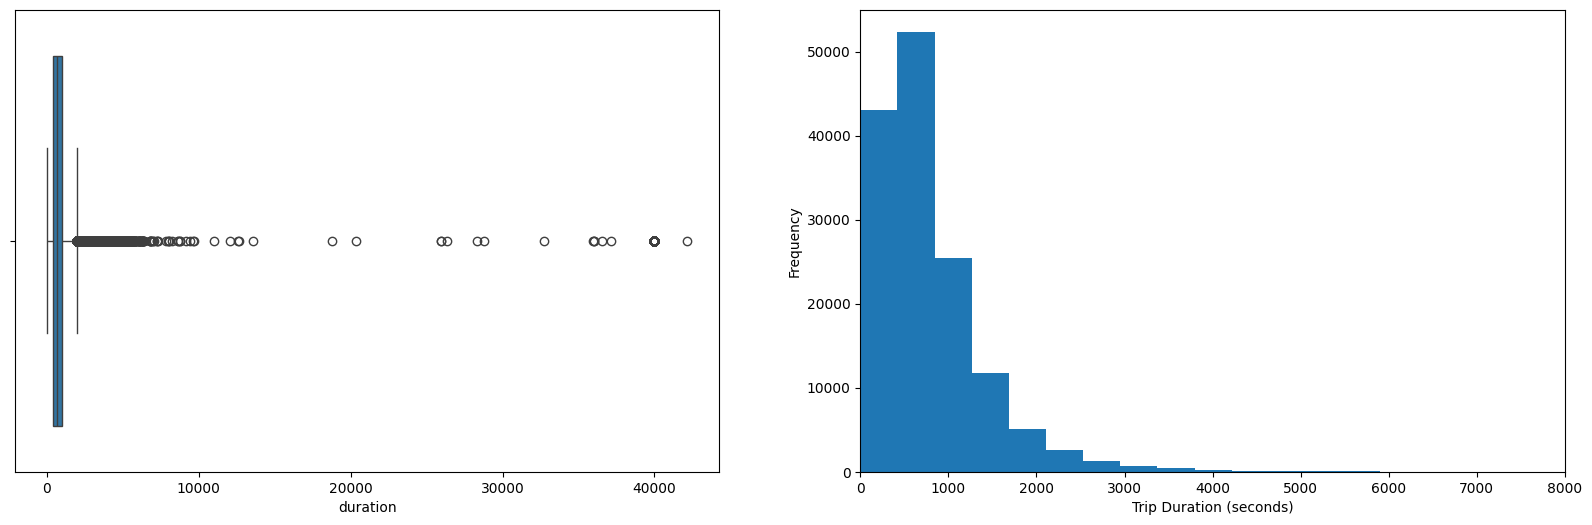

In [16]:
before = train_df['duration']
print("Before dropping duration values")
plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
sns.boxplot(x=before)

plt.subplot(1,2,2)
plt.hist(before,bins=100)
plt.xlim(0,8000)
plt.xlabel("Trip Duration (seconds)")
plt.ylabel("Frequency")

plt.show()

In most of the datasets like, most trips are short (a few minutes to maybe an hour). Anything longer than 2 hours is usually an outlier (example: someone left the meter running, GPS recording error or wrong timestamps).

In [17]:
above_2hrs = train_df[train_df["duration"] > 7200]
above_2hrs.count()

start_lng    1034
start_lat    1034
end_lng      1034
end_lat      1034
datetime     1034
duration     1034
dtype: int64

In [18]:
#dropping trips above 7200 seconds (2 hours)
train_df.drop(above_2hrs.index,axis=0,inplace=True)
train_df.shape

(143464, 6)

After dropping duration values


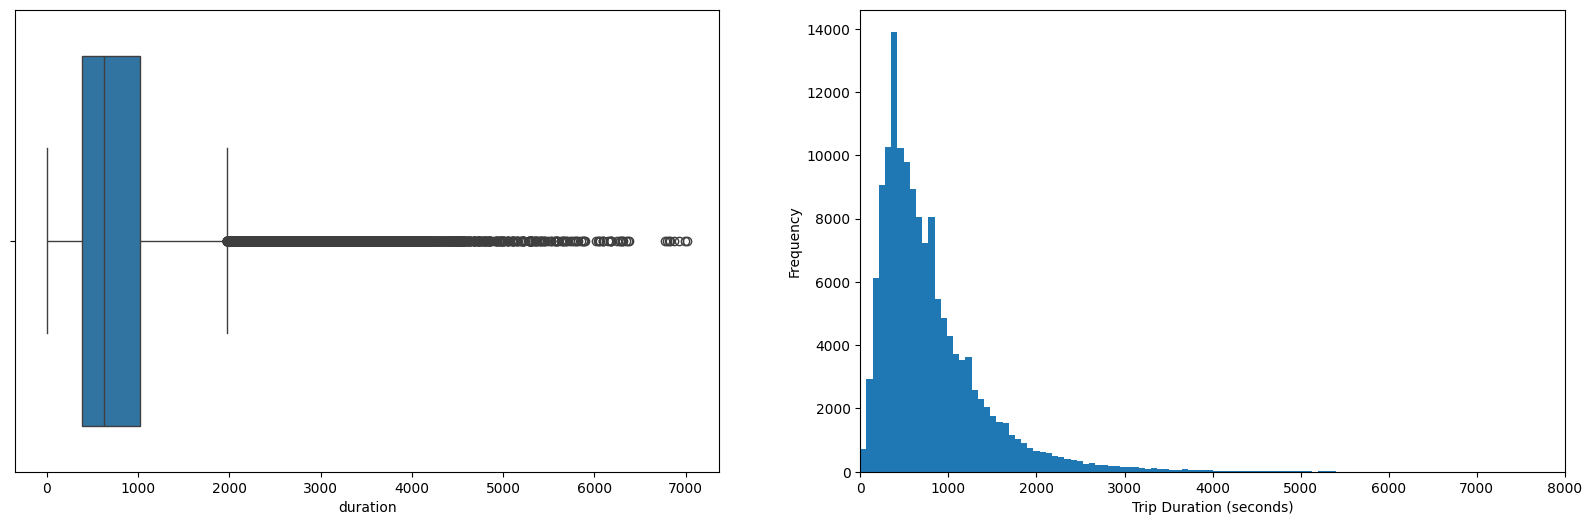

In [19]:
print("After dropping duration values")
plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
sns.boxplot(x=train_df['duration'])

plt.subplot(1,2,2)
plt.hist(train_df['duration'],bins=100)
plt.xlim(0,8000)
plt.xlabel("Trip Duration (seconds)")
plt.ylabel("Frequency")

plt.show()

### Working with **start_lng** 

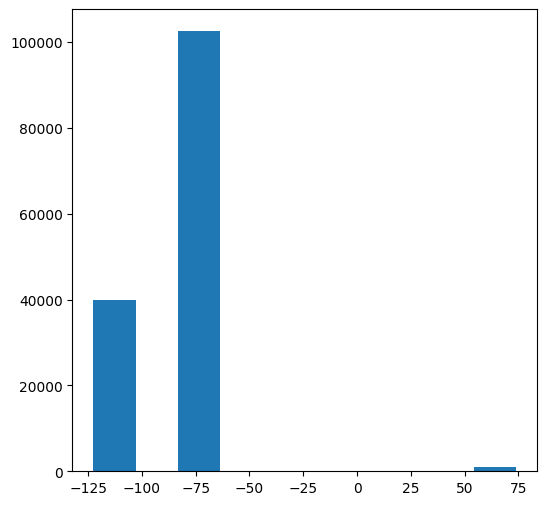

In [20]:
plt.figure(figsize=(6,6))
plt.hist(train_df['start_lng'])
plt.show()

In [21]:
train_df['start_lng'].skew()

np.float64(1.0333473554201729)

In [22]:
percent25 = train_df['start_lng'].quantile(0.25)
percent75 = train_df['start_lng'].quantile(0.75)

IQR = percent75 - percent25

upper_limit = percent75 + 1.5*IQR
lower_limit = percent25 - 1.5*IQR

print("25th percentile: ",round(percent25,2))
print("75th percentile: ",round(percent75,2))
print("IQR: ",round(IQR,2))
print("Upper Limit: ",round(upper_limit,2))
print("Lower Limit: ",round(lower_limit,2))

25th percentile:  -122.39
75th percentile:  -73.97
IQR:  48.42
Upper Limit:  -1.35
Lower Limit:  -195.02


In [23]:
start_lng_outliers = train_df[train_df['start_lng']>upper_limit]

In [24]:
gmap = gmplot.GoogleMapPlotter(
    start_lng_outliers.start_lat.mean(),
    start_lng_outliers.start_lng.mean(),
    4,
    apikey=GOOGLE_MAPS_API_KEY
)
    
gmap.heatmap(start_lng_outliers.start_lat, start_lng_outliers.start_lng)
    
output_file = "gmaps/mismatched_loc_1.html"
gmap.draw(output_file)
print(f"Map saved to: {output_file}")

Map saved to: gmaps/mismatched_loc_1.html


Looks like few data points are mismatched. the start_lng seems to be have marked positive instead of negative. we should fix this.

In [25]:
train_df.loc[start_lng_outliers.index,"start_lng"] = -train_df.loc[start_lng_outliers.index].start_lng 

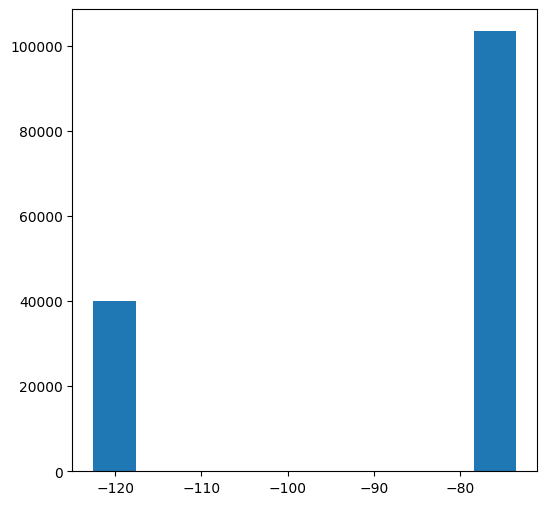

In [26]:
plt.figure(figsize=(6,6))
plt.hist(train_df['start_lng'])
plt.show()

### Working with **end_lng**

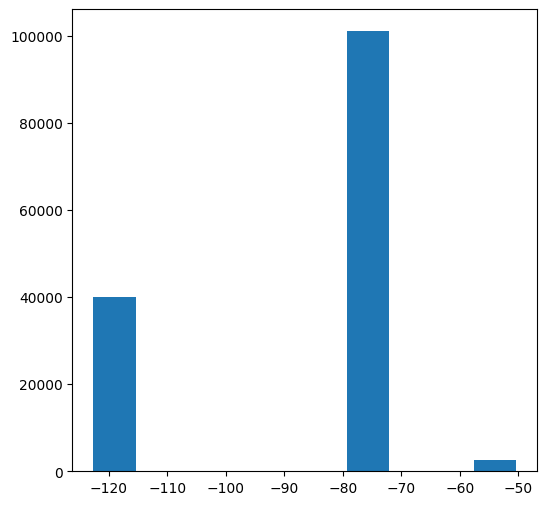

In [27]:
plt.figure(figsize=(6,6))
plt.hist(train_df['end_lng'])
plt.show()

In [29]:
end_lng_outliers = train_df[train_df['end_lng']>-60]

In [30]:
gmap = gmplot.GoogleMapPlotter(
    end_lng_outliers.end_lat.mean(),
    end_lng_outliers.end_lng.mean(),
    4,
    apikey=GOOGLE_MAPS_API_KEY
)
    
gmap.heatmap(end_lng_outliers.end_lat, end_lng_outliers.end_lng)
    
output_file = "gmaps/mismatched_loc_2.html"
gmap.draw(output_file)
print(f"Map saved to: {output_file}")

Map saved to: gmaps/mismatched_loc_2.html


we are in ocean here! lets remove these points

In [31]:
train_df.drop(end_lng_outliers.index,axis=0,inplace=True)

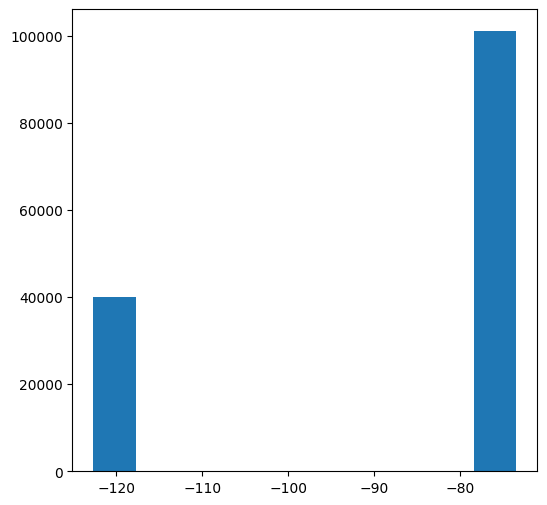

In [32]:
plt.figure(figsize=(6,6))
plt.hist(train_df['end_lng'])
plt.show()

In [33]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140965 entries, 0 to 146000
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   start_lng  140965 non-null  float64       
 1   start_lat  140965 non-null  float64       
 2   end_lng    140965 non-null  float64       
 3   end_lat    140965 non-null  float64       
 4   datetime   140965 non-null  datetime64[ns]
 5   duration   140965 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 7.5 MB
